In [18]:
from pathlib import Path
from datetime import datetime
import json
import simplejson

EXPERIMENT_FOLDER = f'./experiments/vary_pm/{datetime.now().strftime("%d-%m_%H-%M")}'
# EXPERIMENT_FOLDER = "./experiments/vary_pm/24-09_09-40"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [3]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [4]:
NUM_CLASSES = 3
BATCH_SIZE = 32
CHANNEL_SIZE = 5
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [5]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

# Run Experiments

In [6]:
def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class
    )

def create_self_play_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

In [31]:
from itertools import combinations

def test_game(teacher, student, num_tests=5):
    games_played = []
    for _ in range(num_tests):
        inputs, targets = generate_test_batch()
        outputs = play_game(
            inputs, teacher, student, 
            training=False, 
            p_mutate=0,
        )
        games_played.append((inputs, targets, outputs))
    return games_played

In [32]:
class MetaExperiment:
    
    def __init__(
        self, 
        p_mutate=0.5,  
        num_experiments=3,
        create_experiment_fn=create_self_play_experiment,
        **make_experiment_kwargs
    ):
        self.p_mutate = p_mutate
        self.num_experiments = num_experiments
        self.results = None
        self.experiments = [
            {
                'experiment': create_experiment_fn(
                    p_mutate, **make_experiment_kwargs
                ),
                'status': 'Not Run',
                'results': None,
                'index': i,
            }
            for i in range(num_experiments)
        ]
        for item in self.experiments:
            item['experiment'].print_my_history = item['experiment'].print_history
            item['experiment'].print_history = self.print_history
        
    def print_history(self):
        num_complete = len([
            item for item in self.experiments
            if item['status'] == 'Complete'
        ])
        for item in self.experiments:
            if item['status'] == 'Complete':
                print(f"Results of experiment {item['index']}:")
                item['experiment'].print_results()
        for item in self.experiments:
            if item['status'] == 'In Progress':
                print(f"Running experiment {item['index']}", 
                      f'({num_complete}/{self.num_experiments} complete):')
                item['experiment'].print_my_history()
                break
                
    def print_results(self):
        print('Experiment results: ', self.results)

    def is_finished(self):
        return all([
            item['status'] == 'Complete' 
            for item in self.experiments
        ])
    
    def get_experiment_to_run(self):
        for item in self.experiments:
            if item['status'] == 'In Progress':
                return item
        not_run = [
            item
            for item in self.experiments
            if item['status'] == 'Not Run'
        ]
        if len(not_run) == 0:
            return None
        return not_run[0]
    
    def get_experiment_results(self, experiment):
        test_metrics_items = [
            item['test_metrics']
            for item in experiment.training_history
            if 'test_metrics' in item
        ]
        return test_metrics_items[-1]
    
    def _run_next_subexperiment(self):
        experiment_item = self.get_experiment_to_run()
        index = experiment_item['index']
        experiment = experiment_item['experiment']

        self.experiments[index]['status'] = 'In Progress'

        experiment.run(catch_interrupt=False)

        self.experiments[index]['results'] = \
            self.get_experiment_results(experiment)
        self.experiments[index]['status'] = 'Complete'
        
    def _get_results(self):
        return self.measure_zero_shot_coordination()
    
    def _run_internal(self):
        while not self.is_finished():
            self._run_next_subexperiment()
        
        self.results = self._get_results()
            
    def measure_zero_shot_coordination(self):
        results = []

        for item_1, item_2 in combinations(self.experiments, 2):
            e1 = item_1['experiment']
            e2 = item_2['experiment']

            games_played = test_game(e1.teacher, e2.student)
            test_metrics = e1.extract_test_metrics(games_played)
            results.append(test_metrics['mean_ground_truth_f1'])

            games_played = test_game(e2.teacher, e1.student)
            test_metrics = e1.extract_test_metrics(games_played)
            results.append(test_metrics['mean_ground_truth_f1'])

        return results
    
    def run(self, catch_interrupt=True):
        if catch_interrupt:
            try:
                self._run_internal()
            except KeyboardInterrupt:
                pass
            self._run_internal()
        else:
            self._run_internal()
        
        clear_output()
        self.print_history()
        print('Run Stopped.')

In [22]:
meta_experiment = MetaExperiment(0.3)

In [23]:
meta_experiment.run()

Results of experiment 0:
Test Loss: 1.137, Ground Truth F1-Score: 0.961, Student Error: 0.069, Teacher Error: 0.031, Protocol Diversity: 0.982,
Results of experiment 1:
Test Loss: 1.175, Ground Truth F1-Score: 0.96, Student Error: 0.073, Teacher Error: 0.023, Protocol Diversity: 0.961,
Results of experiment 2:
Test Loss: 1.19, Ground Truth F1-Score: 0.953, Student Error: 0.078, Teacher Error: 0.003, Protocol Diversity: 0.946,
Run Stopped.


In [ ]:
# %tensorboard --logdir logs

In [34]:
measure_zero_shot_coordination(meta_experiment)

[0.9500000000000001, 1.0, 0.65, 1.0, 1.0, 1.0]

In [33]:
class VaryPMutateExperiment(MetaExperiment):
    
    def __init__(self, 
                 num_intervals=5, 
                 save_location=None, 
                 **experiment_kwargs):
        self.num_experiments = num_intervals
        self.experiments = [
            {
                'p_mutate': i/num_intervals,
                'experiment': MetaExperiment(
                    p_mutate=i/num_intervals, 
                    **experiment_kwargs
                ),
                'status': 'Not Run',
                'results': None,
                'index': i,
            }
            for i in range(num_intervals+1)
        ]
        for item_1 in self.experiments:
            item_1['experiment'].print_my_history = item_1['experiment'].print_history
            item_1['experiment'].print_history = self.print_history
            item_1['experiment'].print_test_metrics = item_1['experiment'].print_results
            
#             for item_2 in item_1['experiment'].experiments:
#                 item_2['experiment'].print_my_history = item_2['experiment'].print_history
#                 item_2['experiment'].print_history = item_1['experiment'].print_my_history
        
        if save_location is not None:
            self.load_history(save_location)
            
    def load_history(self, history_location):
        experiment_path = Path(history_location)
        for path in experiment_path.glob('*'):
            metadata = json.load((path / 'meta.json').open(mode='r'))
            results = json.load((path / 'results.json').open(mode='r'))
            i = metadata['index']
            self.experiments[i]['results'] = results['zs_coord_f1_scores']
            self.experiments[i]['experiment'].results = results['zs_coord_f1_scores']
            self.experiments[i]['status'] = 'Complete'
    
    def get_experiment_results(self, meta_experiment):
        return meta_experiment.results
    
    def _run_next_subexperiment(self):
        super(VaryPMutateExperiment, self)._run_next_subexperiment()
        self.export_data()
        clear_output()
        self.print_history()
        
    def _get_results(self):
        return None
    
    def export_data(self):
        for item_1 in self.experiments:
            if item_1['status'] == 'Complete':
                try:
                    meta_exp = item_1['experiment']
                    meta_exp_subfolder = \
                        f'{self.save_location}/pm={meta_exp.p_mutate}'
                    Path(meta_exp_subfolder).mkdir()

                    experiment_config = \
                        meta_exp.experiments[0]['experiment'].get_config()
                    meta_data = {
                        'index': item_1['index'], 
                        'p_mutate': meta_exp.p_mutate,
        #                 'experiment_config': experiment_config
                    }
                    meta_data_path = Path(f'{meta_exp_subfolder}/meta.json')
                    with meta_data_path.open(mode='w') as f:
                        json.dump(meta_data, f)

                    results = {
                        'zs_coord_f1_scores': item_1['results']
                    }
                    results_path = Path(f'{meta_exp_subfolder}/results.json')
                    with results_path.open(mode='w') as f:
                        simplejson.dump(results, f)

                    for item_2 in meta_exp.experiments:
                        logs_file_loc = \
                            f"{meta_exp_subfolder}/experiment_{item_2['index']}_logs.json"
                        logs_file_path = Path(logs_file_loc)

                        with logs_file_path.open(mode='w') as f:
                            json.dump(item_2['experiment'].training_history, f)

                    print('Saved experiment data at:', meta_exp_subfolder)
                except FileExistsError:
                    print('Experiment', item_1['index'], 'already saved.')

In [36]:
vary_pm_experiment = VaryPMutateExperiment(save_location=EXPERIMENT_FOLDER)

In [35]:
vary_pm_experiment.run()

Results of experiment 0:
Experiment results:  [0.34375, 0.41875, 0.36250000000000004, 0.6, 0.2625, 0.26875]
Results of experiment 1:
Experiment results:  [0.85, 0.85625, 0.91875, 0.81875, 0.69375, 0.6625]
Results of experiment 2:
Experiment results:  [0.9125, 1.0, 1.0, 1.0, 1.0, 1.0]
Results of experiment 3:
Experiment results:  [0.7875, 0.79375, 0.85, 0.6625, 0.68125, 0.68125]
Results of experiment 4:
Experiment results:  [0.71875, 0.6875, 0.66875, 0.68125, 0.6375, 0.66875]
Results of experiment 5:
Experiment results:  [0.48125000000000007, 0.48125000000000007, 0.44375, 0.5125, 0.5125, 0.49375]
Run Stopped.


In [24]:
vary_pm_experiment.experiments

[{'p_mutate': 0.0,
  'experiment': <__main__.MetaExperiment at 0x240c39d0898>,
  'status': 'Complete',
  'results': [0.34375, 0.41875, 0.36250000000000004, 0.6, 0.2625, 0.26875],
  'index': 0},
 {'p_mutate': 0.2,
  'experiment': <__main__.MetaExperiment at 0x240c3badf60>,
  'status': 'Complete',
  'results': [0.85, 0.85625, 0.91875, 0.81875, 0.69375, 0.6625],
  'index': 1},
 {'p_mutate': 0.4,
  'experiment': <__main__.MetaExperiment at 0x240c3bd0c18>,
  'status': 'Complete',
  'results': [0.9125, 1.0, 1.0, 1.0, 1.0, 1.0],
  'index': 2},
 {'p_mutate': 0.6,
  'experiment': <__main__.MetaExperiment at 0x240c3cc6860>,
  'status': 'Complete',
  'results': [0.7875, 0.79375, 0.85, 0.6625, 0.68125, 0.68125],
  'index': 3},
 {'p_mutate': 0.8,
  'experiment': <__main__.MetaExperiment at 0x240c3ebc4a8>,
  'status': 'Complete',
  'results': [0.71875, 0.6875, 0.66875, 0.68125, 0.6375, 0.66875],
  'index': 4},
 {'p_mutate': 1.0,
  'experiment': <__main__.MetaExperiment at 0x240c3e6c0f0>,
  'status':

In [153]:
vary_pm_experiment.experiments[0]['experiment'].experiments[0]['experiment'].get_config()

{'max_epochs': 40,
 'steps_per_epoch': 50,
 'epochs_optimised': 40,
 'loss_fn': 'complete_loss_fn',
 'play_params': {'p_mutate': 0.0},
 'test_freq': 5,
 'test_steps': 25,
 'optimiser_config': {'name': 'RMSprop',
  'learning_rate': 0.01,
  'decay': 0.0,
  'rho': 0.9,
  'momentum': 0.0,
  'epsilon': 1e-07,
  'centered': False}}

In [37]:
df = pd.DataFrame([
    {
        'Mutation Probability': item['p_mutate'],
        'Zero-Shot Coordination Score': score,
    }
    for item in vary_pm_experiment.experiments
    if item['status'] == 'Complete'
    for score in item['results']
])

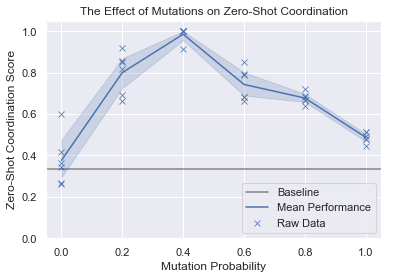

In [38]:
sns.lineplot(x=[-2, 2], y=[1/NUM_CLASSES, 1/NUM_CLASSES], dashes=True, color=(0.1, 0.1, 0.1, 0.5), label='Baseline')
sns.lineplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=df, label='Mean Performance')
sns.scatterplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=df, marker='x', label='Raw Data')
plt.ylim([0, 1.05])
plt.xlim([-.05, 1.05])
plt.title('The Effect of Mutations on Zero-Shot Coordination')
plt.show()